OWLv2 Evaluations

### Imports

In [1]:
import requests
import pandas as pd
from PIL import Image, ImageFont
import torch
from torchvision import ops
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
from PIL import ImageDraw
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD
from collections import namedtuple
import numpy as np
import cv2

from transformers import Owlv2Processor, Owlv2ForObjectDetection

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Initializing OWLv2 model

Code taken from the following [documentation](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/OWLv2/Zero_and_one_shot_object_detection_with_OWLv2.ipynb)

In [3]:
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

In [4]:
images_dir="/Users/a788/Desktop/BPTI/train/images"
labels_dir="/Users/a788/Desktop/BPTI/train/labels"

### Defining inputs

In [5]:
classes = ["auto", "bus", "car", "lcv", "motorcycle", "multiaxle", "tractor", "truck"]

In [6]:
image_names = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f)) and f.endswith('.jpg')]

In [7]:
len(image_names)

8218

### Helper functions for label definition

Converting [coordinates](https://stackoverflow.com/questions/67110781/how-to-convert-cv2-rectangle-bounding-box-to-yolov4-annotation-format-relative) with some help of Generative AI.


In [8]:
def read_labels(label_file_path):
    labels = []
    try:
        with open(label_file_path, 'r') as file:
            for line in file:
                # Split into parts
                parts = line.strip().split()
                # Convert strings to floats, found on stackoverflow
                formatted_parts = [int(parts[0])] + [float(x) for x in parts[1:]]
                labels.append(formatted_parts)
    except:
        print(f"errror, {label_file_path} not found")
    return labels

def calculate_absolute_box(center_x, center_y, width, height, img_size):
    # Converts cv2.rectangle coordinates to the ones appropriate to OWLv2 model
    x_min = (center_x * img_size[0]) - (width * img_size[0] / 2)
    y_min = (center_y * img_size[1]) - (height * img_size[1] / 2)
    x_max = (center_x * img_size[0]) + (width * img_size[0] / 2)
    y_max = (center_y * img_size[1]) + (height * img_size[1] / 2)
    return (round(x_min, 3), round(y_min, 3), round(x_max, 3), round(y_max, 3))

### Label initialization

In [9]:
images = []
absolute_boxes = []
absolute_boxes_dict = {}

## !ATTENTION!

I was not able to load several images due to weird processing and forwarding through the model. Thus, the following narrative is going to be analysed through viewpoint of one image. In the other notebook, I take several examples of different pictures to compare their metrics.

Nevertheless, I did write the functions as to adapt to multiple-image inputs. If the error of messed up metrics would be resolved, all folder could be taken as an input and explored. 

Example of the error I am referencing is provided in the section of ``Forwarding results through OWLv2``

Thus, any image can be selected from `image_names` with `[x:x+1]` and analysed through the pipeline made. 

`0<x<len(image_names)`

The following intakes each label file and compares it to the image name.

In [10]:
# Seleting an image for image_names list
for image_name in image_names[2:3]:
    image_path = os.path.join(images_dir, image_name)
    label_file_path = os.path.join(labels_dir, image_name.replace('.jpg', '.txt'))
    try:
        with Image.open(image_path) as img:
            img_copy = img.copy()
            images.append(img_copy)
    except:
        print(f"error, no {image_name}")
        continue

    labels = read_labels(label_file_path)
    
    image_size = [960, 960]
    
    # Convert labels to appropriate sizes conforming to the models predictions
    absolute_boxes = [
        (classes[class_id],) + calculate_absolute_box(center_x, center_y, width, height, image_size)
        for class_id, center_x, center_y, width, height in labels
    ]
    # Storing converted values in dictionary for multi-input processing
    absolute_boxes_dict[image_name] = absolute_boxes
absolute_boxes_dict

{'highway_3554_2020-08-26.jpg': [('car', 474.0, 729.0, 588.0, 958.5),
  ('car', 589.5, 640.5, 720.0, 870.0),
  ('car', 372.0, 253.5, 427.5, 339.0)]}

### Inputs

In [11]:
try:
    inputs = processor(text=classes, images=images, return_tensors="pt")
except Exception as e:
    print(f"Failed to process images and classes: {e}")

In [12]:
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([8, 16])
attention_mask torch.Size([8, 16])
pixel_values torch.Size([1, 3, 960, 960])


### Resizing image

Manipulation of pixel values helps in maintaining consistency in image representation. This was discussed in the provided article as well as used in the [documentation](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/OWLv2/Zero_and_one_shot_object_detection_with_OWLv2.ipynb)


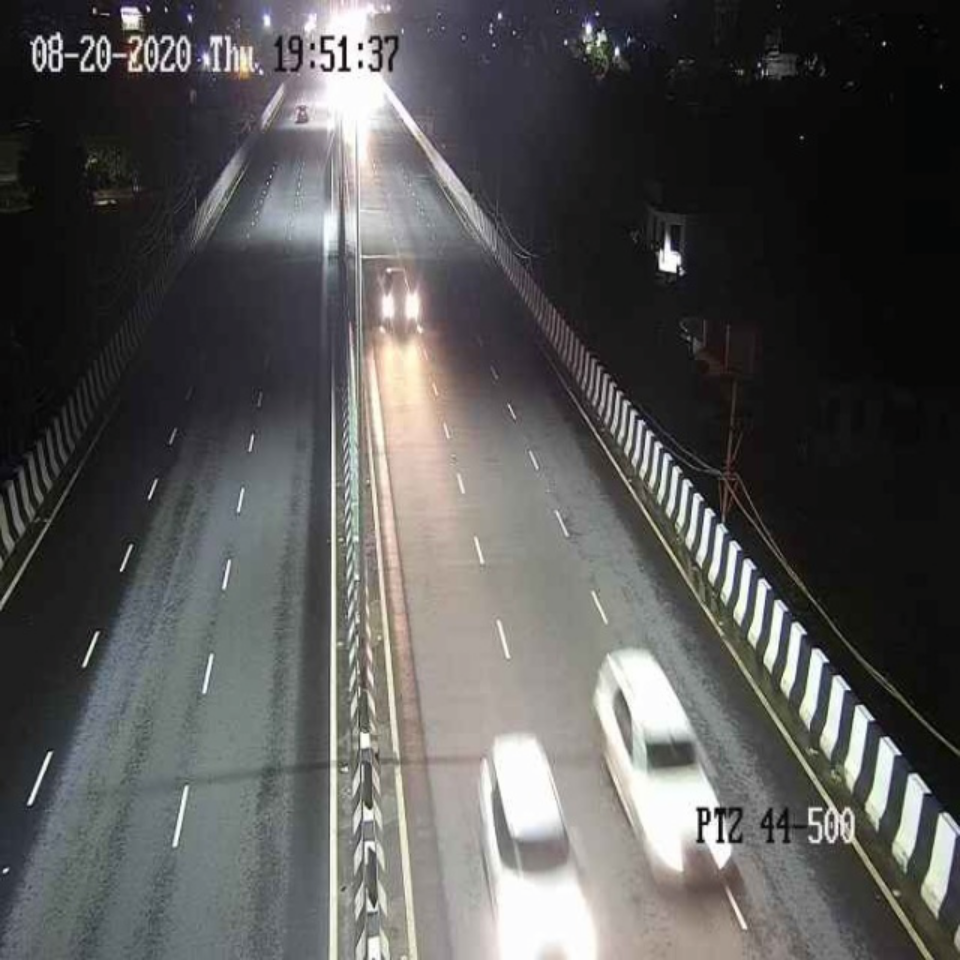

In [13]:
def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

unnormalized_images = []

for i in range(len(inputs.pixel_values)):
    unnormalized_images.append(get_preprocessed_image(inputs.pixel_values[i]))
    
unnormalized_images[0]

### Forwarding results through OWLv2

In [14]:
%%time
with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = [x.size[::-1] for x in unnormalized_images]
    results = processor.post_process_object_detection(outputs, threshold=0.36, target_sizes=target_sizes)
    print("forwarded successfully")

forwarded successfully
CPU times: user 1min 13s, sys: 14.9 s, total: 1min 27s
Wall time: 15.2 s


In [15]:
results

[{'scores': tensor([0.3820, 0.3953, 0.4777, 0.4839]),
  'labels': tensor([2, 2, 2, 2]),
  'boxes': tensor([[294.1180, 104.0888, 309.0411, 123.6800],
          [377.3891, 262.7112, 422.4328, 337.4409],
          [593.1201, 648.7984, 735.1708, 893.1564],
          [473.3717, 728.5277, 596.2983, 955.0886]])}]

## !THE ISSUE!

An issue arises when trying to process and forward more than one image. Results from one image are correct and precise. However, when processing several images (with the previous image in the list), the results change significantly. Above, results of the first image are provided. Below, the first and later images have wrong results.

In [16]:
"""

[{'scores': tensor([]),
  'labels': tensor([], dtype=torch.int64),
  'boxes': tensor([], size=(0, 4))},
 {'scores': tensor([0.4545, 0.4472, 0.4818, 0.3923]),
  'labels': tensor([0, 0, 0, 1]),
  'boxes': tensor([[364.6202,  16.6603, 378.7443,  36.5787],
          [341.9470,  46.5379, 356.0335,  70.4450],
          [423.3973, 109.2554, 443.1403, 137.0027],
          [286.4667, 262.8269, 329.5949, 364.4982]])},
 {'scores': tensor([]),
  'labels': tensor([], dtype=torch.int64),
  'boxes': tensor([], size=(0, 4))},
 {'scores': tensor([0.4483]),
  'labels': tensor([1]),
  'boxes': tensor([[263.3171, 165.6036, 320.3872, 280.9458]])}]
  
"""

"\n\n[{'scores': tensor([]),\n  'labels': tensor([], dtype=torch.int64),\n  'boxes': tensor([], size=(0, 4))},\n {'scores': tensor([0.4545, 0.4472, 0.4818, 0.3923]),\n  'labels': tensor([0, 0, 0, 1]),\n  'boxes': tensor([[364.6202,  16.6603, 378.7443,  36.5787],\n          [341.9470,  46.5379, 356.0335,  70.4450],\n          [423.3973, 109.2554, 443.1403, 137.0027],\n          [286.4667, 262.8269, 329.5949, 364.4982]])},\n {'scores': tensor([]),\n  'labels': tensor([], dtype=torch.int64),\n  'boxes': tensor([], size=(0, 4))},\n {'scores': tensor([0.4483]),\n  'labels': tensor([1]),\n  'boxes': tensor([[263.3171, 165.6036, 320.3872, 280.9458]])}]\n  \n"

### Predicted results

Here predicted results are stored in a dictionary (multi-input adjustment).

## !ATTENTION! 

Here as well we have to define the image number. Any image can be selected from `image_names` with `[x:x+1]` and analysed through the pipeline made. 

`0<x<len(image_names)`

In [17]:
accuracy_results_dict = {}
    
for index, (image_name, unnormalized_image) in enumerate(zip(image_names[2:3], unnormalized_images)):

    # Process and store accuracy results
    accuracy_results = []

    scores = results[index]["scores"].tolist()
    labels = results[index]["labels"].tolist()
    boxes = results[index]["boxes"].tolist()

    for box, score, label in zip(boxes, scores, labels):
        box = [round(coord, 2) for coord in box]
        label_text = classes[label]
        accuracy_results.append((label_text, *box))
        
    # Reverse order assumption
    accuracy_results.reverse()
    
    #print(accuracy_results)
    accuracy_results_dict[image_name] = accuracy_results

## Manuall check of accuracy

### Our true labels:

In [18]:
absolute_boxes_dict

{'highway_3554_2020-08-26.jpg': [('car', 474.0, 729.0, 588.0, 958.5),
  ('car', 589.5, 640.5, 720.0, 870.0),
  ('car', 372.0, 253.5, 427.5, 339.0)]}

### Our predicted labels:

In [19]:
accuracy_results_dict

{'highway_3554_2020-08-26.jpg': [('car', 473.37, 728.53, 596.3, 955.09),
  ('car', 593.12, 648.8, 735.17, 893.16),
  ('car', 377.39, 262.71, 422.43, 337.44),
  ('car', 294.12, 104.09, 309.04, 123.68)]}

### OWLv2 zero-shot object detection

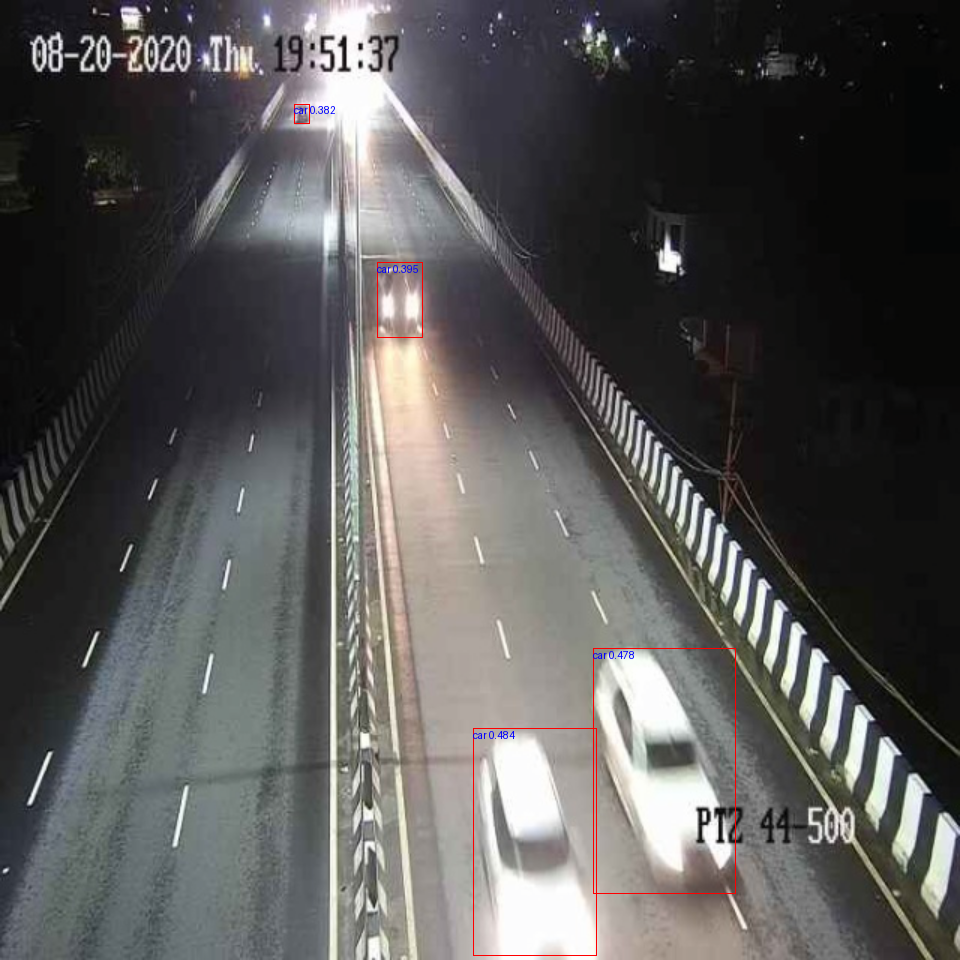

In [20]:
visualized_images = []

for index, (imag, result) in enumerate(zip(unnormalized_images, results)):
    # Copy the image to draw on it
    visualized_image = imag.copy()
    draw = ImageDraw.Draw(visualized_image)
    
    scores = results[index]["scores"].tolist()
    labels = results[index]["labels"].tolist()
    boxes = results[index]["boxes"].tolist()

    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box]
        x1, y1, x2, y2 = box
        # Draw the rectangle on the image
        draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")

        # Fetching label text using label index and draw it on the image
        label_text = classes[label]
        draw.text(xy=(x1, y1), text=f"{label_text} {round(score, 3)}", fill="blue", fontsize=3000
                 )
    
    visualized_images.append(visualized_image)

display(visualized_images[0])

### Helper functions for metric calculations

Code based on this [documentation](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

**Important (and not quite right) assumption is made here:**

The order (reversed) of predicted object boxes (locations) matches those of ground truth label order. For instance:

**GT:**

{'highway_3554_2020-08-26.jpg': 

  [('car', 474.0, 729.0, 588.0, 958.5),
  
  ('car', 589.5, 640.5, 720.0, 870.0),
  
  ('car', 372.0, 253.5, 427.5, 339.0)]}

**Pred:**

{'highway_3554_2020-08-26.jpg': 

  [('car', 473.37, 728.53, 596.3, 955.09),
  
  ('car', 593.12, 648.8, 735.17, 893.16),
  
  ('car', 377.39, 262.71, 422.43, 337.44),
  
  ('car', 294.12, 104.09, 309.04, 123.68)]}
  

For some (as this one) images metric calculations work well, but for others (as will be shown in the other narrative), it is nothing alike.

In [21]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

### DataFrame for storing results

In [22]:
data = []

for image_name, gt_boxes in absolute_boxes_dict.items():
    pred_boxes = accuracy_results_dict.get(image_name, [])
    max_length = max(len(gt_boxes), len(pred_boxes))
    
    for i in range(max_length):
        if i < len(gt_boxes):
            gt = gt_boxes[i]
        else:
            gt = (np.nan, np.nan, np.nan, np.nan, np.nan)

        if i < len(pred_boxes):
            pred = pred_boxes[i]
        else:
            pred = (np.nan, np.nan, np.nan, np.nan, np.nan)

        if not (np.isnan(gt[1]).any() or np.isnan(pred[1]).any()):
            iou = bb_intersection_over_union(gt[1:], pred[1:])
        else:
            iou = np.nan
        
        data.append({
            "Image Name": image_name,
            "GT Label": gt[0],
            "GT Box": gt[1:],
            "Pred Label": pred[0],
            "Pred Box": pred[1:],
            "IoU": iou
        })

df = pd.DataFrame(data)
df

,Image Name,GT Label,GT Box,Pred Label,Pred Box,IoU
0,highway_3554_2020-08-26.jpg,car,"(474.0, 729.0, 588.0, 958.5)",car,"(473.37, 728.53, 596.3, 955.09)",0.913327
1,highway_3554_2020-08-26.jpg,car,"(589.5, 640.5, 720.0, 870.0)",car,"(593.12, 648.8, 735.17, 893.16)",0.768084
2,highway_3554_2020-08-26.jpg,car,"(372.0, 253.5, 427.5, 339.0)",car,"(377.39, 262.71, 422.43, 337.44)",0.713409
3,highway_3554_2020-08-26.jpg,NaN,"(nan, nan, nan, nan)",car,"(294.12, 104.09, 309.04, 123.68)",NaN


### Metrics

Definitions based on this [documentation](https://medium.com/@henriquevedoveli/metrics-matter-a-deep-dive-into-object-detection-evaluation-ef01385ec62)

True Positive (TP): These are instances where the object detection model *correctly identifies and localizes objects*, thus, count of entries with a valid IoU score (above a set threshold) and maching labels.

False Positive (FP): These are cases where the model incorrectly identifies an object that does not exist in the ground truth or where the predicted bounding box has an IOU score below the defined threshold. Thus, the count of entries where GT Label is NaN or IoU<threshold.

False Negative (FN): FN represents instances where the model fails to detect an object that is present in the ground truth. In other words, the count of entries where Pred Label is NaN.

True Negative (TN): Not applicable in object detection. It represents correctly rejecting the absence of objects, but in object detection, the goal is to detect objects rather than the absence of objects.

Calculate Precision and Recall:

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

Compute the F1 Score:

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

In [23]:
iou_threshold = 0.3

TP = df[(df['IoU'] >= iou_threshold) & (df['GT Label'] == df['Pred Label'])].shape[0]
FP = df[(df['GT Label'].isna()) | (df['IoU'] < iou_threshold)].shape[0]
FN = df['Pred Label'].isna().sum()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

True Positives (TP): 3
False Positives (FP): 1
False Negatives (FN): 0
Precision: 0.75
Recall: 1.00
F1 Score: 0.86


### Improving F1 Score:

- Optimal threshold for object detection (0.35-0.39) - *implemented*
- Data augmentation (unnormalizing pixel for images) - *implemented*
- Lower threshold for IoU - *implemented*
- Do not include labels as prerequisites of TP / fine-tuning model on ground-truth labels for more accurate labeling - *time/knowledge constraint*